In [114]:
import osmnx as ox
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon
from glob import glob


In [127]:
saar_park = (ox.geometries_from_place("Saarbrücken", tags={'parking':True})

         .loc[:, ["geometry"]]                 

         .query("geometry.type == 'Polygon'")  

      )

saar_park.head()

/tmp/ipykernel_373523/2277540664.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  saar_park = (ox.geometries_from_place("Saarbrücken", tags={'parking':True})


geometry
element_type osmid                                                      
way          23326546  POLYGON ((6.96481 49.21078, 6.96494 49.21089, ...
             23492303  POLYGON ((6.89684 49.23043, 6.89708 49.23023, ...
             23505385  POLYGON ((6.90061 49.23038, 6.90056 49.23046, ...
             23505395  POLYGON ((6.89822 49.23017, 6.89838 49.22990, ...
             23546505  POLYGON ((6.92163 49.25776, 6.92171 49.25777, ...

In [198]:
saar_park.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

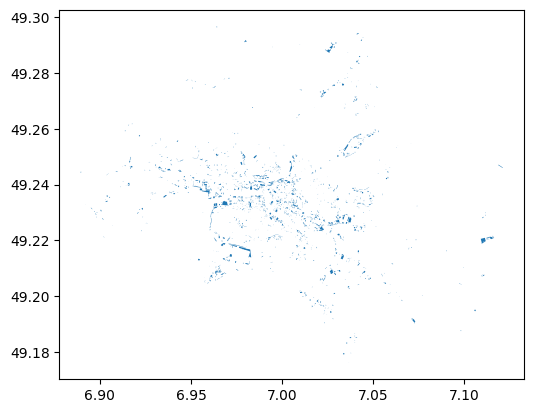

In [130]:
saar_park.plot()

In [144]:
saar_park_area = []
for i in range(0,len(saar_park.geometry)):
    saar_park_area.append(saar_park.geometry.iloc[i].area)

In [163]:
#find the argument of top 10 largest areas
#These are the 10 largest areas of parking lots in Saarbrücken
saar_park_area = np.array(saar_park_area)
large_parking_lots = saar_park_area.argsort()[-10:][::-1]

In [165]:
saar_park_area[large_parking_lots]

array([4.75185818e-06, 3.27295107e-06, 3.12003052e-06, 2.32064929e-06,
       1.95990622e-06, 1.65849279e-06, 1.63021957e-06, 1.61631999e-06,
       1.59825582e-06, 1.48975438e-06])

In [231]:
saar_park.iloc[list(large_parking_lots)]

geometry
element_type osmid                                                       
way          117681090  POLYGON ((6.97629 49.21737, 6.97649 49.21778, ...
relation     14390648   POLYGON ((6.96751 49.23386, 6.96753 49.23390, ...
way          144988486  POLYGON ((7.10910 49.22058, 7.10916 49.22059, ...
             33584765   POLYGON ((6.95674 49.23752, 6.95832 49.23738, ...
             32510016   POLYGON ((7.03709 49.22833, 7.03704 49.22822, ...
             292040432  POLYGON ((7.02361 49.28836, 7.02374 49.28849, ...
             204657442  POLYGON ((7.00525 49.24784, 7.00552 49.24618, ...
             749107174  POLYGON ((7.02245 49.22374, 7.02243 49.22369, ...
             41417334   POLYGON ((7.02766 49.20917, 7.02800 49.20894, ...
             123144888  POLYGON ((7.03221 49.21352, 7.03239 49.21382, ...

In [230]:
list(large_parking_lots)

[276, 1986, 434, 60, 49, 702, 538, 1015, 90, 323]

In [236]:
output_dir = '/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken_Polygon'
os.makedirs(output_dir, exist_ok=True) 

for i in large_parking_lots:
    polygon = saar_park.iloc[i].geometry
    
    polygon_geojson = gpd.GeoSeries([polygon])
    
    output_path = os.path.join(output_dir, f'parking_lot_{i}_polygon.geojson')
    polygon_geojson.to_file(output_path, driver='GeoJSON')



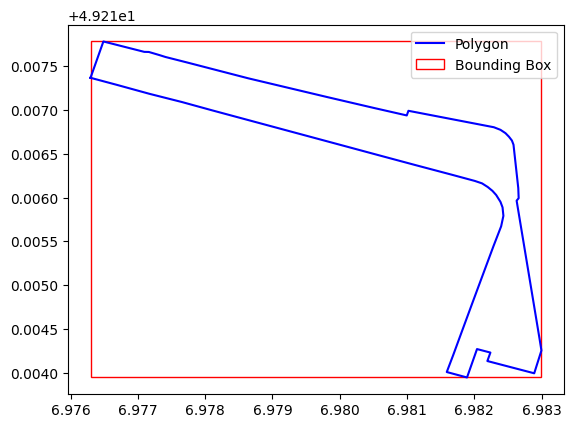

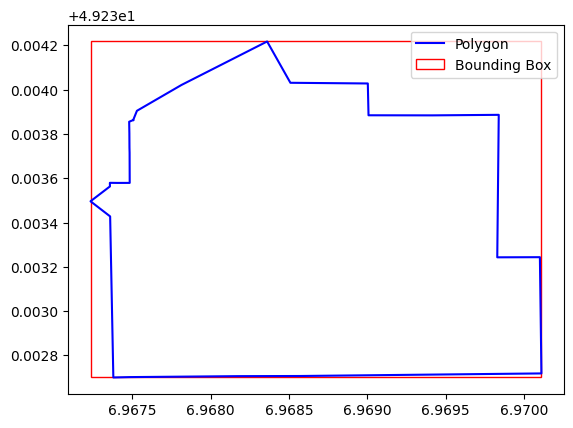

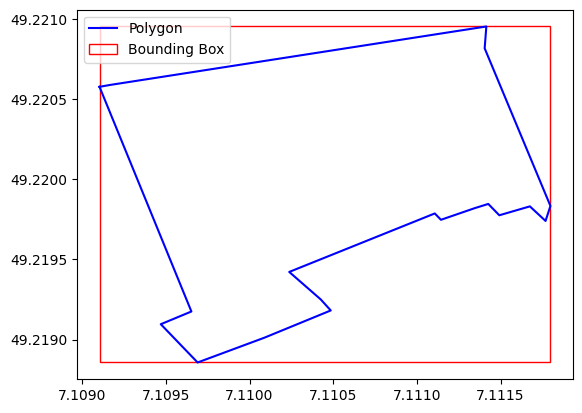

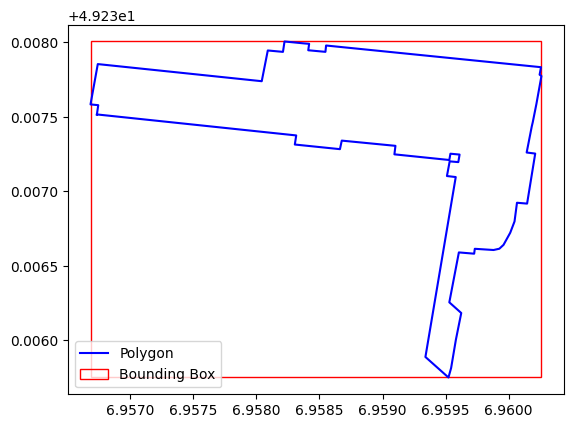

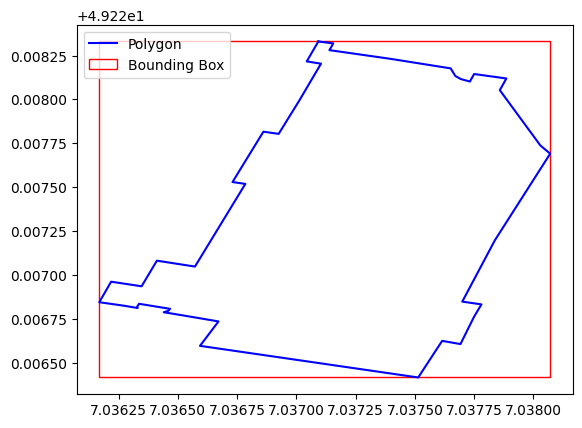

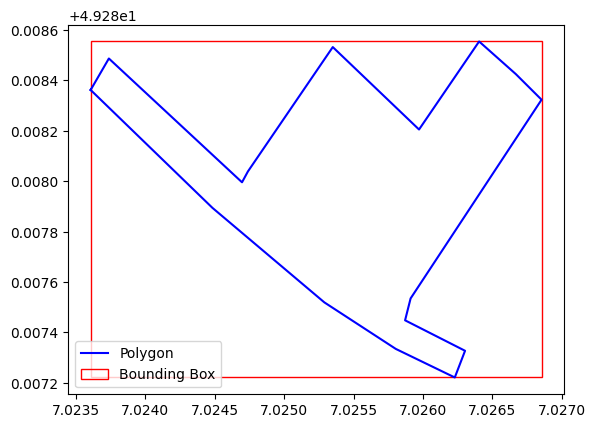

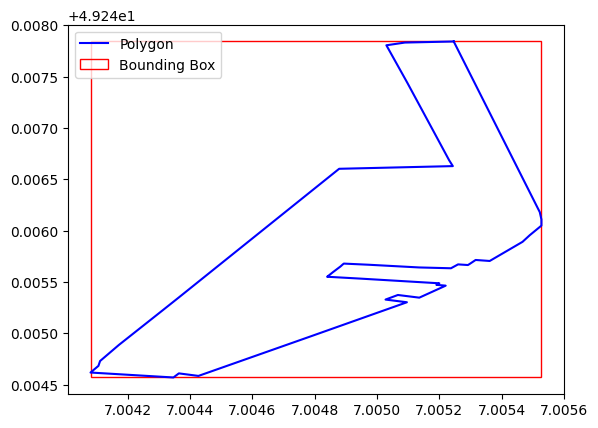

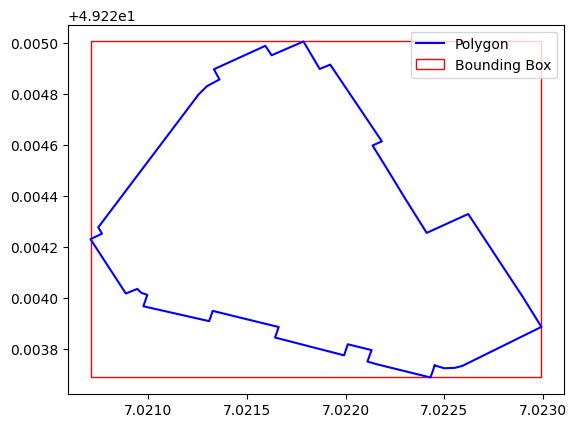

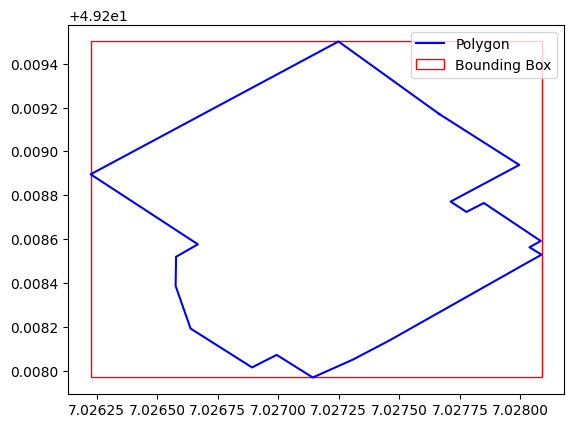

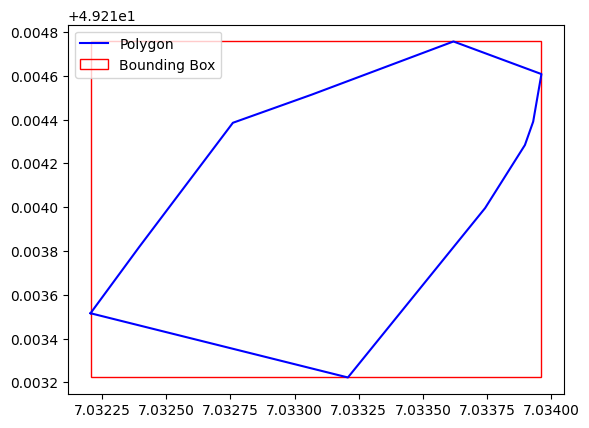

In [201]:
output_dir = '/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken'

for i in large_parking_lots:
    polygon = saar_park.iloc[i].geometry
    min_x, min_y, max_x, max_y = polygon.bounds
    fig, ax = plt.subplots()

    x, y = polygon.exterior.xy
    ax.plot(x, y, color='blue', label='Polygon')

    # Plot the bounding box
    bbox = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                            fill=False, color='red', label='Bounding Box')
    ax.add_patch(bbox)

    ax.legend()

    plt.show()

     # Save the bounding box as a GeoJSON file
    bbox_geojson = gpd.GeoSeries([Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])])
    bbox_geojson.crs = saar_park.crs  # Set the same coordinate reference system as the original data
    output_path = os.path.join(output_dir, f'parking_lot_{i}_bbox.geojson') 
    bbox_geojson.to_file(output_path, driver='GeoJSON')

    



Planet Image Download

In [202]:
import os
import requests
import json
import sys
import time
import pathlib  # Added pathlib
from requests.auth import HTTPBasicAuth

In [212]:
def read_geom(file_path):
    with open(file_path) as f:
        bbox = json.load(f)['features'][0]['geometry']
        return bbox
    
def place_order(request, auth):
    response = requests.post('https://api.planet.com/compute/ops/orders/v2', data=json.dumps(request), auth=auth, headers=headers)
    print(response)
    order_id = response.json()['id']
    print(order_id)
    order_url = 'https://api.planet.com/compute/ops/orders/v2' + '/' + order_id
    return order_url

def poll_for_success(order_url, auth):
    while True:
        r = requests.get(order_url, auth=(api_key, ""))
        response = r.json()
        state = response['state']
        print(state)
        end_states = ['success', 'failed', 'partial']
        if state in end_states:
            break
        time.sleep(10)


def download_results(results, geojson_file, overwrite=False):
    results_urls = [r['location'] for r in results]
    results_names = [r['name'] for r in results]
    print('{} items to download'.format(len(results_urls)))
    
    # Extract the parking lot number from the GeoJSON file name
    parking_lot_number = os.path.splitext(geojson_file)[0]
    
    for url, name in zip(results_urls, results_names):
        path = pathlib.Path(os.path.join('/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken', parking_lot_number, name))
        
        if overwrite or not path.exists():
            print('downloading {} to {}'.format(name, path))
            path.parent.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
            r = requests.get(url, allow_redirects=True)
            open(path, 'wb').write(r.content)
        else:
            print('{} already exists, skipping {}'.format(path, name))


In [237]:
geojson_folder = '/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/'
geojson_files = [f for f in os.listdir(geojson_folder) if f.endswith('.geojson')]


In [214]:
try:
    os.environ['PL_API_KEY'] = 'PLAKd3ecc6fb183b44e5b79b34a602e75754'
    api_key = os.getenv('PL_API_KEY')
except Exception as e:
    print("Failed")
    sys.exit()

headers = {'Content-Type':'application/json'}

# Get a list of all GeoJSON files in the folder
geojson_files = [f for f in os.listdir(geojson_folder) if f.endswith('.geojson')]

# Iterate through each GeoJSON file
for geojson_file in geojson_files:
    print(f"Processing {geojson_file}...")
    
    # Construct the full file path
    geojson_path = os.path.join(geojson_folder, geojson_file)
    
    # Read bounding box geometry from the GeoJSON file
    clip_aoi = read_geom(geojson_path)

    # Define the clip tool
    clip = {
        "clip": {
            "aoi": clip_aoi
        }
    }

    # Get images that overlap with our AOI 
    geometry_filter = {
    "type": "GeometryFilter",
    "field_name": "geometry",
    "config": clip_aoi
    }

    # Get images acquired within a date range
    date_range_filter = {
    "type": "DateRangeFilter",
    "field_name": "acquired",
    "config": {
        "gte": "2023-06-15T09:25:50.000Z",
        "lte": "2023-06-22T09:25:50.000Z"
    }
    }

    # Only get images which have <5% cloud coverage
    cloud_cover_filter = {
    "type": "RangeFilter",
    "field_name": "cloud_cover",
    "config": {
        "lt": 0.05
    }
    }

    # Vombine our geometry, date, cloud filters
    combined_filter = {
    "type": "AndFilter",
    "config": [geometry_filter, date_range_filter, cloud_cover_filter]
    }

    item_type = "PSScene"
    # API request object
    search_request = {
    "item_types": [item_type], 
    "filter": combined_filter
    }


    # Fire off the POST request for searching imagery
    search_result = requests.post(
        'https://api.planet.com/data/v1/quick-search',
        auth=HTTPBasicAuth(api_key, ''),
        json=search_request)
    
    # Parse the search result JSON
    geojson = search_result.json()
    
    # Extract image IDs from the search results
    image_ids = [feature['id'] for feature in geojson['features']]

    # Create an order request with the clip tool and image IDs
    request = {
        "name": os.path.splitext(geojson_file)[0],  # Use the GeoJSON file name without extension
        "products": [
            {
                "item_ids": image_ids,
                "item_type": "PSScene",
                "product_bundle": "visual",
            }
        ],
        "tools": [clip]
    }
    print(request)

    order_url = place_order(request, auth=(api_key, ""))
    print(order_url)

    poll_for_success(order_url, api_key)

    zip_delivery = {"delivery": {"single_archive": True, "archive_type": "zip"}}
    request_zip = request.copy()
    request_zip.update(zip_delivery)
    request_zip

    r = requests.get(order_url, auth=(api_key, ""))
    response = r.json()
    results = response['_links']['results']
    print(results)

    download_results(results, geojson_file)

    print(f"Processing of {geojson_file} complete.")


print("Processing of all GeoJSON files complete.")



    

Processing parking_lot_60_bbox.geojson...
{'name': 'parking_lot_60_bbox', 'products': [{'item_ids': ['20230620_093818_45_2421', '20230616_093743_54_2465', '20230615_093305_22_241e', '20230615_093922_93_24c4'], 'item_type': 'PSScene', 'product_bundle': 'visual'}], 'tools': [{'clip': {'aoi': {'type': 'Polygon', 'coordinates': [[[6.956686, 49.2357502], [6.9602592, 49.2357502], [6.9602592, 49.2380065], [6.956686, 49.2380065], [6.956686, 49.2357502]]]}}}]}
<Response [202]>
25fabb06-f841-482d-81fc-a994cb969962
https://api.planet.com/compute/ops/orders/v2/25fabb06-f841-482d-81fc-a994cb969962
queued
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
success
[{'delivery': 'success', 'expires_at': '2023-09-29T09:52:56.122Z', 'location': 'https://api.planet.com/compute/ops/download/?token=eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJleHAiOjE2OTU5ODExNzYsInN1YiI6IkFUNzZYL2svaitMSVF4QmNQOUhoUmdZWDNQZnBwWHg1dHdyNDA1bEtweklLYmZwZXlHN24rY

/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230616_093743_54_2465_metadata.json'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230616_093743_54_2465_3B_Visual_clip.tif to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230616_093743_54_2465_3B_Visual_clip.tif


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230616_093743_54_2465_3B_Visual_clip.tif'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093922_93_24c4_3B_Visual_clip.tif to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093922_93_24c4_3B_Visual_clip.tif


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093922_93_24c4_3B_Visual_clip.tif'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093922_93_24c4_metadata.json to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093922_93_24c4_metadata.json


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093922_93_24c4_metadata.json'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_metadata.json to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_metadata.json


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_metadata.json'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_3B_Visual_clip.tif to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_3B_Visual_clip.tif


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_3B_Visual_clip.tif'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230620_093818_45_2421_metadata.json to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230620_093818_45_2421_metadata.json


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230620_093818_45_2421_metadata.json'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230620_093818_45_2421_3B_Visual_clip.tif to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230620_093818_45_2421_3B_Visual_clip.tif


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230620_093818_45_2421_3B_Visual_clip.tif'>
  open(path, 'wb').write(r.content)


downloading 25fabb06-f841-482d-81fc-a994cb969962/manifest.json to /home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/manifest.json


/tmp/ipykernel_373523/3376719748.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/manifest.json'>
  open(path, 'wb').write(r.content)


Processing of parking_lot_60_bbox.geojson complete.
Processing parking_lot_434_bbox.geojson...
{'name': 'parking_lot_434_bbox', 'products': [{'item_ids': ['20230620_093818_45_2421', '20230616_094017_29_24cf', '20230615_093305_22_241e', '20230615_093922_93_24c4'], 'item_type': 'PSScene', 'product_bundle': 'visual'}], 'tools': [{'clip': {'aoi': {'type': 'Polygon', 'coordinates': [[[7.1091034, 49.2188571], [7.1117981, 49.2188571], [7.1117981, 49.2209529], [7.1091034, 49.2209529], [7.1091034, 49.2188571]]]}}}]}
<Response [202]>
b7425f60-8b0f-4ea8-a687-50a00a470407
https://api.planet.com/compute/ops/orders/v2/b7425f60-8b0f-4ea8-a687-50a00a470407
queued
running
running
running
running
running


KeyboardInterrupt: 

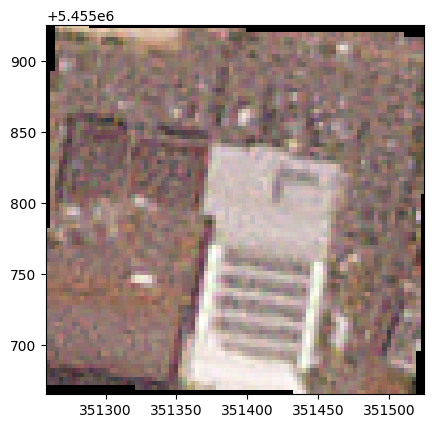

<Axes: >

In [221]:
from rasterio.plot import show
file = rasterio.open('/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_3B_Visual_clip.tif')
show(file)


Masking Planet Images

In [ ]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

input_directory = '/home/idisc02/Desktop/i2sc/detect-car-LR/data/data/Saarbruecken/Parking0/7cee5845-d74f-4a16-bf76-91cdb5c5f13d/PSScene'

# Create a new directory for saving masked JPEG images
output_directory = '/home/idisc02/Desktop/i2sc/detect-car-LR/data/data/Saarbruecken/Parking0/7cee5845-d74f-4a16-bf76-91cdb5c5f13d/PSScene' # Replace with your desired output directory
os.makedirs(output_directory, exist_ok=True)

# Path to the OSM GeoJSON file
osm_file = gpd.read_file('/home/idisc02/Desktop/i2sc/detect-car-LR/data/Trier_Parking_Mask/parking_lot_3.geojson')

# Loop through each image file in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.tif'):
        # Construct the full path to the image file
        tif_file = os.path.join(input_directory, filename)

        # Load the TIFF file;
        raster = rasterio.open(tif_file)

        # Reproject the overlayed region to match the CRS of the TIFF
        osm_reprojected = osm_file.to_crs(raster.crs)

        # Create a mask of the overlayed region
        mask_shape = [osm_reprojected.geometry.iloc[0]]

        # Apply the mask to the TIFF image without inverting
        image_data, image_transform = mask(raster, shapes=mask_shape, invert=False)

        # Plot the modified image with a black background
        fig, ax = plt.subplots(figsize=(10, 10))
        show(image_data, ax=ax, transform=image_transform, cmap='gray', vmin=0, vmax=255)
        # osm_reprojected.plot(ax=ax, facecolor='none')

        # Set the background color to black
        ax.set_facecolor('black')

        # Create a file name for the masked image in the output directory
        output_image_path = os.path.join(output_directory, f'masked_{filename[:-4]}.jpg')

        # Save the masked image as a JPEG file
        plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Ensure to close the raster file
        raster.close()

print("All images processed and saved in", output_directory)


In [244]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [261]:
def masked_img(input_dir, osm_file_path):
    output_dir = input_dir + '_masked'
    os.makedirs(output_dir, exist_ok=True)
    osm_file = gpd.read_file(osm_file_path)

    print("HI")

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):

            print("HI")

            # Construct the full path to the image file
            tif_file = os.path.join(input_dir, filename)

            # Load the TIFF file;
            raster = rasterio.open(tif_file)

            # Reproject the overlayed region to match the CRS of the TIFF
            osm_reprojected = osm_file.to_crs(raster.crs)

            # Create a mask of the overlayed region
            mask_shape = [osm_reprojected.geometry.iloc[0]]

            # Apply the mask to the TIFF image without inverting
            image_data, image_transform = mask(raster, shapes=mask_shape, invert=False)

            with rasterio.open("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene_masked/masked_geotiff.tif", "w", driver="GTiff", height=image_data.shape[0], width=image_data.shape[1], transform=image_transform, crs=raster.crs) as dst:
                dst.write(image_data)

            # Close the new GeoTIFF dataset
            dst.close()

            # # Plot the modified image with a black background
            # fig, ax = plt.subplots(figsize=(10, 10))
            # show(image_data, ax=ax, transform=image_transform, cmap='gray', vmin=0, vmax=255)

            # # Set the background color to black
            # ax.set_facecolor('black')

            # # Create a file name for the masked image in the output directory
            # output_image_path = os.path.join(output_dir, f'masked_{filename[:-4]}.jpg')

            # # Save the masked image as a JPEG file
            # plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
            # plt.close()

            # Ensure to close the raster file
            raster.close()

    print("All images processed and saved in", output_dir)





In [267]:
import rasterio
import geopandas as gpd
from PIL import Image

# Open the GeoTIFF file
with rasterio.open("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230616_093743_54_2465_3B_Visual_clip.tif") as src:

    # Open the shapefile
    shapefile = gpd.read_file("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken_Polygon/parking_lot_49_polygon.geojson").geometry.iloc[0]

    # Create a mask from the shapefile
    mask = shapefile.convex_hull

    # Mask the GeoTIFF file
    masked_image = src.read(3, masked=mask)

    # Save the masked image as a JPEG file
    image = Image.fromarray(masked_image)
    image.save("masked_image.jpg")

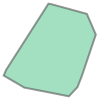

In [268]:
shapefile.convex_hull

In [262]:
masked_img("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene",
           "/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken_Polygon/parking_lot_60_polygon.geojson")

HI
HI


TypeError: Integer band count is required.

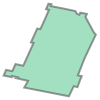

In [240]:
gpd.read_file("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken_Polygon/parking_lot_49_polygon.geojson").geometry.iloc[0]

In [248]:
import rasterio
import geopandas as gpd

# Open the GeoTIFF dataset
with rasterio.open("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken/parking_lot_60_bbox/25fabb06-f841-482d-81fc-a994cb969962/PSScene/20230615_093305_22_241e_3B_Visual_clip.tif") as src:
    # Get the GeoTIFF dataset's CRS
    src_crs = src.crs

# Open the GeoPandas polygon
polygon = gpd.read_file("/home/idisc02/Desktop/detect-car-LR/notebooks/data_collection/Saarbrucken_Polygon/parking_lot_49_polygon.geojson").geometry.iloc[0]

# Create a list of geometries from the GeoPandas polygon
geometries = polygon

# Mask the GeoTIFF dataset using the GeoPandas polygon
masked_geotiff, masked_transform = rasterio.mask.mask(src, geometries, crop=True)

# Create a new GeoTIFF dataset from the masked GeoTIFF image and transform
with rasterio.open("masked_geotiff.tif", "w", driver="GTiff", height=masked_geotiff.shape[1], width=masked_geotiff.shape[2], transform=masked_transform, crs=src_crs) as dst:
    dst.write(masked_geotiff)

TypeError: 'Polygon' object is not iterable